In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sta
%matplotlib inline
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
import scipy.stats as stats

In [2]:
# import data
data = pd.read_csv('P1train.csv')
data_dictionary= pd.read_csv('county_facts_dictionary.csv')
df=data.copy()
y1_train = df['total_votes_change_percentage']
y2_train = df['dem_change_percentage']
y1= 'total_votes_change_percentage'
y2= 'dem_change_percentage'
X_train= df.drop(['total_votes_change_percentage','dem_change_percentage'], axis=1)
X_train

,state_abbr,total_votes_2012,votes_dem_2012,votes_gop_2012,PST045214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
0,MN,7181,2772,4409,15679,15629,6.0,24.6,15.7,48.9,...,0.0,0.0,0,0,179942,11273,24494,40,1671.60,9.3
1,MI,13933,5936,7997,26121,25949,4.8,20.3,21.5,50.6,...,0.0,28.1,698616,8387,221210,8437,60229,67,416.34,62.3
2,TX,5483,1225,4258,19936,20202,4.8,17.8,14.4,37.1,...,0.0,17.6,0,378967,163334,8527,4601,1,928.55,21.8
3,NE,10004,3279,6725,20919,20780,6.2,24.9,17.4,49.4,...,0.0,14.7,0,147778,148986,7398,9218,56,750.23,27.7
4,IN,39139,22885,16254,143339,137974,4.5,16.1,11.4,50.2,...,1.5,25.2,1799286,683154,1530793,11968,287796,521,394.51,349.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,AL,6374,2048,4326,13977,13906,6.1,22.7,18.0,51.1,...,0.0,30.2,270809,131874,75456,5491,5640,2,608.84,22.8
2496,OH,9693,3911,5782,23331,23770,5.4,21.7,18.0,50.9,...,0.0,0.0,0,11415,124229,5424,15334,9,430.10,55.3
2497,KS,3837,951,2886,9385,9533,6.6,22.6,21.1,50.8,...,0.0,39.6,0,91801,109669,11776,13731,1,715.34,13.3
2498,FL,75926,17757,58169,163422,151372,5.7,22.6,14.5,48.9,...,2.6,31.5,74894,148932,1107974,7499,135111,1127,1011.61,149.6


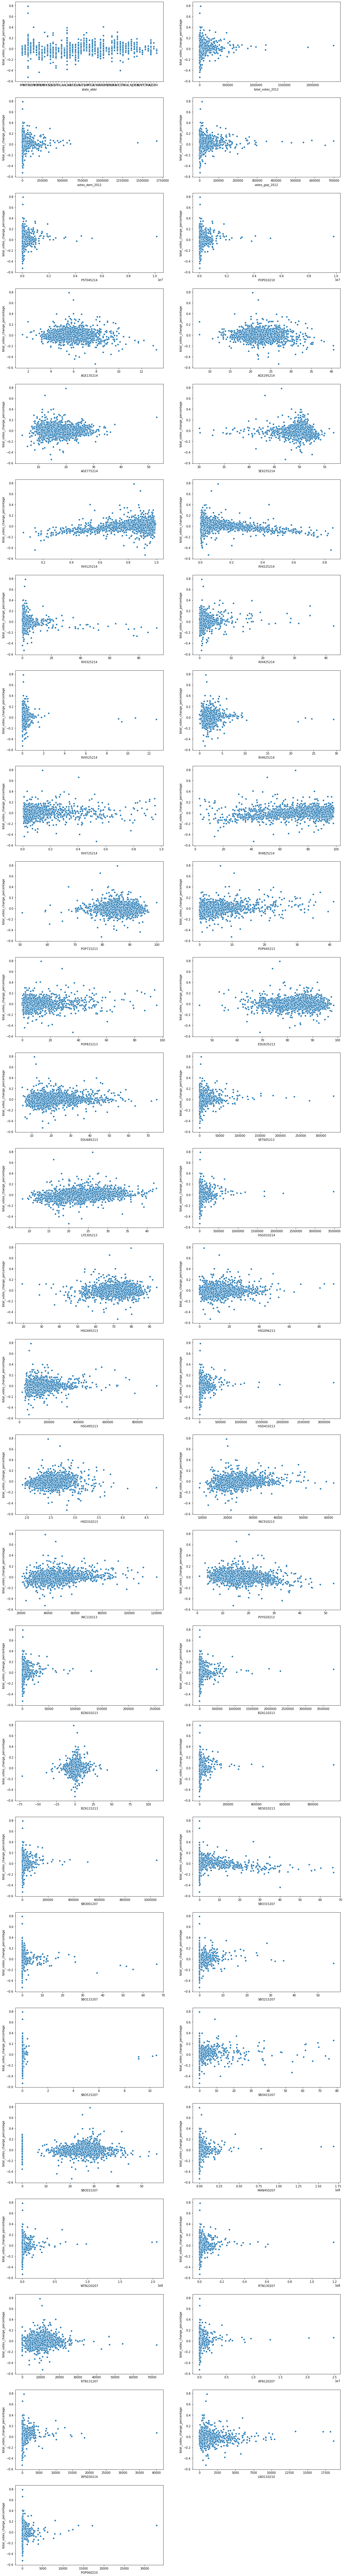

In [3]:
# Plot scatter plot of each variable against 'total_votes_change_percentage'
count=1
plt.subplots(figsize=(20, 168))
for i in X_train.columns:
    plt.subplot(28,2,count)
    sns.scatterplot(X_train[i],df[y1])
    count+=1
plt.show()

In [4]:
# load the functions to be used,
# 'modelFitting' fuction has been modified: added '~ C(state_abbr)+RHI225214+'

# %run "util_formula_new.py"


import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import KFold
import itertools

"""
The function obtain the model fitting results
feature_set: is the collection of input predictors used in the model
data: is the dataframe containing all data
y: is the response vector
@return: a Series of quantities related to the model for model evaluation and selection
"""

def modelFitting(y, feature_set, data):
    # Fit model on feature_set and calculate RSS
    formula = y + ' ~ C(state_abbr)+RHI225214+' + '+'.join(feature_set) + '+1'

    # fit the regression model
    model = smf.ols(formula=formula, data=data).fit()
    return model;


"""
The function obtain the results given a regression model feature set
feature_set: is the collection of input predictors used in the model
data: is the dataframe containing all data
y: is the response vector
@return: a Series of quantities related to the model for model evaluation and selection
"""
def processSubset(y, feature_set, data):
    # Fit model on feature_set and calculate RSS
    try:
        regr = modelFitting(y, feature_set, data);
        R2 = regr.rsquared;
        ar2 = regr.rsquared_adj;
        sse = regr.ssr;
        return {"model":feature_set, "SSE": sse, "R2":-R2, "AR2": -ar2, "AIC": regr.aic, "BIC": regr.bic, "Pnum": 2+len(feature_set)}
    except:
        return {"model": ["1"], "SSE": float("inf"), "R2": 0, "AR2": 0, "AIC": float("inf"), "BIC": float("inf"), "Pnum": 0}

"""
The function find the regression results for all predictor combinations with fixed size
k: is the number of predictors (excluding constant)
data: is the dataframe containing all data
X: is the predictor name list
y: is the response vector
@return: a dataframe containing the regression results of the evaluated models
"""
def getAll(k, y, X, data):
    results = []
    # evaluate all the combinations with k predictors
    for combo in itertools.combinations(X, k):
        results.append(processSubset(y, combo, data))

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results);
    models['Pnum'] = k;
    print("Processed ", models.shape[0], "models on", k, "predictors")
    # Return the best model, along with some other useful information about the model
    return models


"""
The function find the Mallow's Cp based on the full model and existing regression results
models: is the dataframe containing the regression results of different models
fullmodel: is the model containing all predictors to calculate the Cp statistic
@return: a dataframe of models with Cp statistics calculated
"""
def getMallowCp(models, fullmodel):
    nobs = fullmodel.nobs;
    sigma2 = fullmodel.mse_resid;
    models['Cp'] = models['SSE']/sigma2 + 2*(models['Pnum']+3) - nobs
    return models

"""
The function find the best models among all lists using the criterion specified
models: is the dataframe containing the regression results of different models
criterion: is the selection critierion, can take values "AIC", "BIC", "Cp", "AR2", "R2" (only for educational purpose)
k: is the number of predictors as the constraints, if None, all models are compared
@return: the best model satisfied the requirement
"""
def findBest(models, criterion='AIC', k=None):
    # the list of models with given predictor number
    if k is None:
        submodels = models;
    else:
        submodels = models.loc[models['Pnum']==k,];

    # Use the criterion to find the best one
    bestm = submodels.loc[submodels[criterion].idxmin(0), ];
    # return the selected model
    return bestm;


"""
The function use forward selection to find the best model given criterion
models: is the dataframe containing the regression results of different models
X: is the name list of all predictors to be considered
y: is the response vector
data: is the dataframe containing all data
criterion: is the selection critierion, can take values "AIC", "BIC", "Cp", "AR2", "R2" (only for educational purpose)
fullmodel: is the full model to evaluate the Cp criterion
@return: the best model selected by the function
"""
def forward(y, X, data, criterion="AIC", fullmodel = None):
    remaining = X;   
    selected = []

    basemodel = processSubset(y, '1', data)
    current_score = basemodel[criterion]
    best_new_score = current_score;

    while remaining: # and current_score == best_new_score:
        scores_with_candidates = []
        
        for candidate in remaining:
            # print(candidate)
            scores_with_candidates.append(processSubset(y, selected+[candidate], data))
                        
        models = pd.DataFrame(scores_with_candidates)

        # if full model is provided, calculate the Cp
        if fullmodel is not None:
            models = getMallowCp(models, fullmodel);
            
        best_model = findBest(models, criterion, k=None)
        best_new_score = best_model[criterion];

        if current_score > best_new_score:
            selected = best_model['model'];
            remaining = [p for p in X if p not in selected]
            print(selected)
            current_score = best_new_score
        else :
            break;
            
    model = modelFitting(y, selected, data)
    return model

"""
The function use backward elimination to find the best model given criterion
models: is the dataframe containing the regression results of different models
X: is the name list of all predictors to be considered
y: is the response vector
data: is the dataframe containing all data
criterion: is the selection critierion, can take values "AIC", "BIC", "Cp", "AR2", "R2" (only for educational purpose)
fullmodel: is the full model to evaluate the Cp criterion
@return: the best model selected by the function
"""
def backward(y, X, data, criterion="AIC", fullmodel = None):
    remaining = X;
    removed = []
    basemodel = processSubset(y, remaining, data)
    current_score = basemodel[criterion]
    best_new_score = current_score;

    while remaining: # and current_score == best_new_score:
        scores_with_candidates = []
        
        for combo in itertools.combinations(remaining, len(remaining)-1):
            scores_with_candidates.append(processSubset(y, combo, data))
                        
        models = pd.DataFrame(scores_with_candidates)
        # if full model is provided, calculate the Cp
        if fullmodel is not None:
            models = getMallowCp(models, fullmodel);
            
        best_model = findBest(models, criterion, k=None)
        best_new_score = best_model[criterion];

                
        if current_score > best_new_score:
            remaining = best_model['model'];
            removed = [p for p in X if p not in remaining]
            print(removed)
            current_score = best_new_score
        else :
            break;
            
    model = modelFitting(y, remaining, data)
    return model



"""
The function compute the cross validation results 
X: is the dataframe containing all predictors to be included
y: is the response vector
data: is the dataframe of all data
kf: is the kfold generated by the function
@return: the cross validated MSE 
"""
def CrossValidation(y, X, data, kf):
    results = []
    formula = y + '~' + '+'.join(X)

    # evaluate all accuracy based on the folds
    for train_index, test_index in kf:
        d_train, d_test = data.ix[train_index,], data.ix[test_index,]

        # fit the model and evaluate the prediction
        lmfit = smf.ols(formula=formula, data=d_train).fit()
        pred = lmfit.predict(d_test)
        prederror = ((pred - d_test[y]) ** 2).mean();
        results.append(prederror);
        
    # Wrap everything up in a nice dataframe
    return results;


In [5]:
# Processed all 5 predictor models, must include 'state_abbr','RHI225214'

TOP_candidate = X_train.drop(['state_abbr','RHI225214'],axis=1).columns.tolist()
y = y1

fullmodel = modelFitting(y, TOP_candidate, df);

# enumerate all models and obtain the results
models = pd.DataFrame({"model":[], "SSE": [], "R2":[], "AR2": [], "AIC": [], "BIC": [], "Pnum":[]})
# for i in range(1,4):
#     models = models.append(getAll(i, y, candidate, df));

models = models.append(getAll(3, y, TOP_candidate, df));

# get the Mallow's Cp Statistic
# models = getMallowCp(models, fullmodel)

Processed  20825 models on 3 predictors


In [6]:
# find the best 3 predictors other than 'state_abbr','RHI225214'
result_best_predictors= findBest(models, 'AIC')
result_best_predictors.model

('RHI325214', 'LFE305213', 'HSG495213')

In [7]:
formula = 'total_votes_change_percentage ~ RHI225214 + state_abbr + RHI325214 + LFE305213 + HSG495213 + 1'

bfit1 = smf.ols(formula, df).fit()

bfit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     total_votes_change_percentage   R-squared:                       0.385
Model:                                       OLS   Adj. R-squared:                  0.372
Method:                            Least Squares   F-statistic:                     29.43
Date:                           Sun, 26 Sep 2021   Prob (F-statistic):          4.30e-217
Time:                                   18:04:09   Log-Likelihood:                 3388.1
No. Observations:                           2500   AIC:                            -6670.
Df Residuals:                               2447   BIC:                            -6361.
Df Model:                                     52                                         
Covariance Type:                       nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0269      0.012     -2.201      0.028      -0.051      -0.003
state_abbr[T.AR]    -0.0012      0.012     -0.101      0.920      -0.025       0.023
state_abbr[T.AZ]    -0.0255      0.020     -1.272      0.204      -0.065       0.014
state_abbr[T.CA]    -0.0437      0.014     -3.109      0.002      -0.071      -0.016
state_abbr[T.CO]    -0.0682      0.013     -5.212      0.000      -0.094      -0.043
state_abbr[T.CT]    -0.0465      0.028     -1.689      0.091      -0.100       0.007
state_abbr[T.DE]     0.0218      0.038      0.582      0.561      -0.052       0.095
state_abbr[T.FL]     0.0419      0.012      3.413      0.001       0.018       0.066
state_abbr[T.GA]     0.0150      0.010      1.463      0.144      -0.005       0.035
state_abbr[T.HI]    -0.1591      0.034     -4.686      0.000      -0.226      -0.093
state_abbr[T.IA]    -0.0883      0.012     -7.425      0.000      -0.112      -0.065
state_abbr[T.ID]    -0.1314      0.014     -9.075      0.000      -0.160      -0.103
state_abbr[T.IL]    -0.0432      0.012     -3.752      0.000      -0.066      -0.021
state_abbr[T.IN]    -0.0185      0.012     -1.576      0.115      -0.042       0.005
state_abbr[T.KS]    -0.0577      0.012     -4.926      0.000      -0.081      -0.035
state_abbr[T.KY]     0.0125      0.011      1.096      0.273      -0.010       0.035
state_abbr[T.LA]     0.0018      0.012      0.147      0.883      -0.022       0.026
state_abbr[T.MA]    -0.1029      0.021     -4.829      0.000      -0.145      -0.061
state_abbr[T.MD]    -0.0512      0.018     -2.855      0.004      -0.086      -0.016
state_abbr[T.ME]    -0.0604      0.019     -3.204      0.001      -0.097      -0.023
state_abbr[T.MI]    -0.0597      0.012     -4.879      0.000      -0.084      -0.036
state_abbr[T.MN]    -0.0973      0.012     -8.031      0.000      -0.121      -0.074
state_abbr[T.MO]    -0.0260      0.011     -2.306      0.021      -0.048      -0.004
state_abbr[T.MS]    -0.0157      0.011     -1.373      0.170      -0.038       0.007
state_abbr[T.MT]    -0.0696      0.013     -5.173      0.000      -0.096      -0.043
state_abbr[T.NC]     0.0062      0.011      0.560      0.576      -0.016       0.028
state_abbr[T.ND]    -0.0577      0.014     -4.159      0.000      -0.085      -0.030
state_abbr[T.NE]    -0.0365      0.012     -3.024      0.003      -0.060      -0.013
state_abbr[T.NH]    -0.0870      0.023     -3.761      0.000      -0.132      -0.042
state_abbr[T.NJ]    -0.0064      0.018     -0.358      0.720      -0.042       0.029
state_abbr[T.NM]    -0.1224      0.015     -8.231      0.000      -0.152      -0.093
state_abbr[T.NV]    -0.0111      0.019     -0.575      0.565      -0.049

# Model Diagnostics

<Figure size 432x432 with 0 Axes>

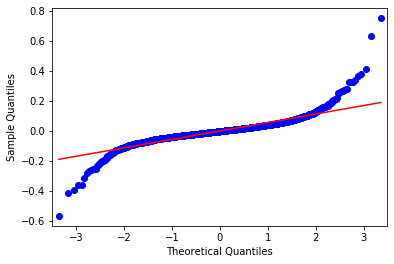

In [11]:
# Normal Q-Q plot 
# check the normality of the data
fig = plt.figure(figsize=(6,6))
fig = sm.qqplot(bfit1.resid, stats.distributions.norm, line='r') 

In [16]:
# refit the model after removing the outliers 
df2= df.drop([578,2274,785], axis=0)
formula = 'total_votes_change_percentage ~ RHI225214 + state_abbr + RHI325214 + LFE305213 + HSG495213 + 1'
bfit2 = smf.ols(formula, df2).fit()
# bfit2.summary()

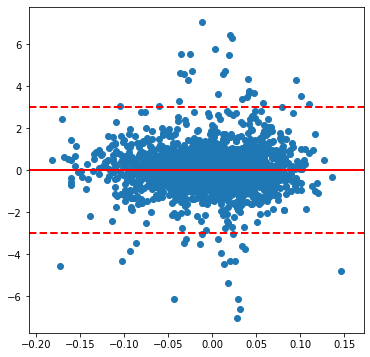

In [10]:
# check the residuals against fitted values
fig = plt.figure(figsize=(6,6))
plt.scatter(bfit2.fittedvalues, bfit2.resid_pearson)
plt.axhline(y=0, linewidth=2, color = 'r')
plt.axhline(y=3, linestyle='dashed', linewidth=2, color = 'r')
plt.axhline(y=-3, linestyle='dashed', linewidth=2, color = 'r')

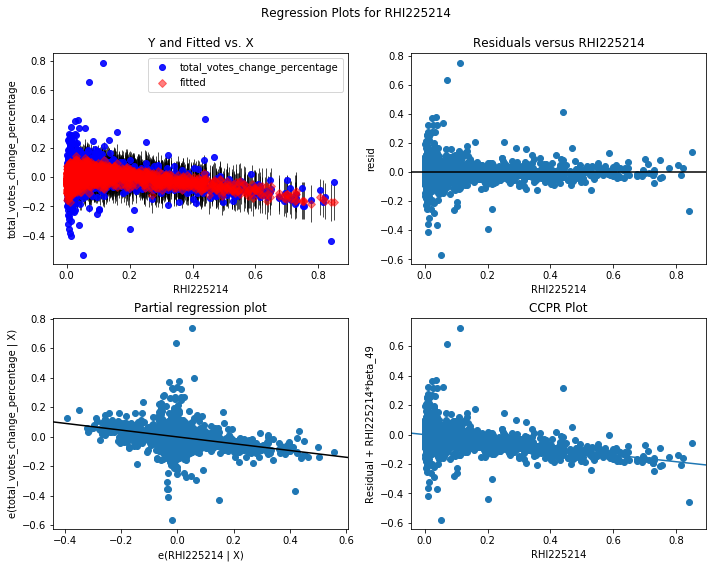

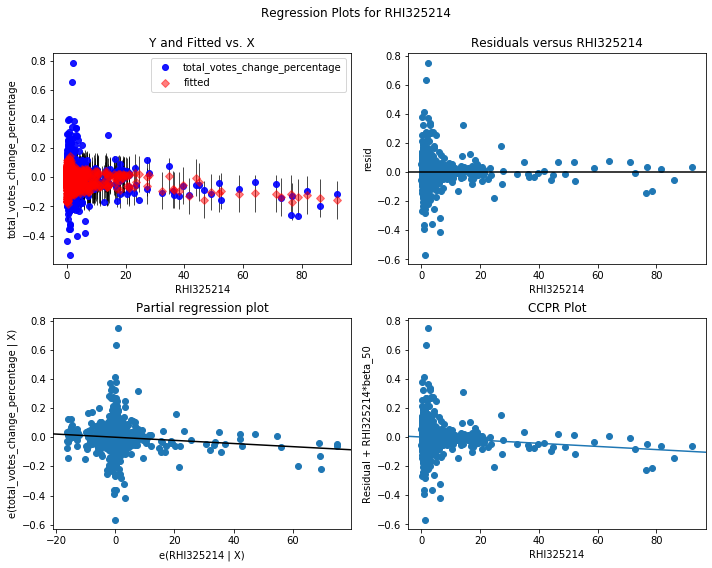

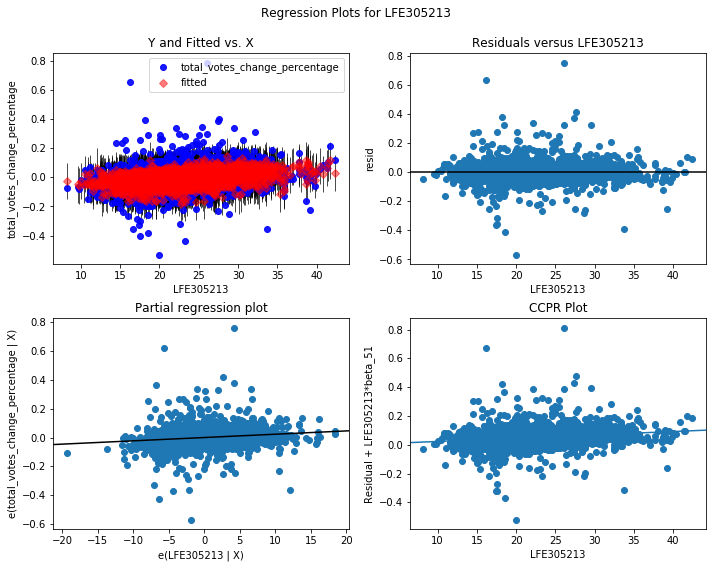

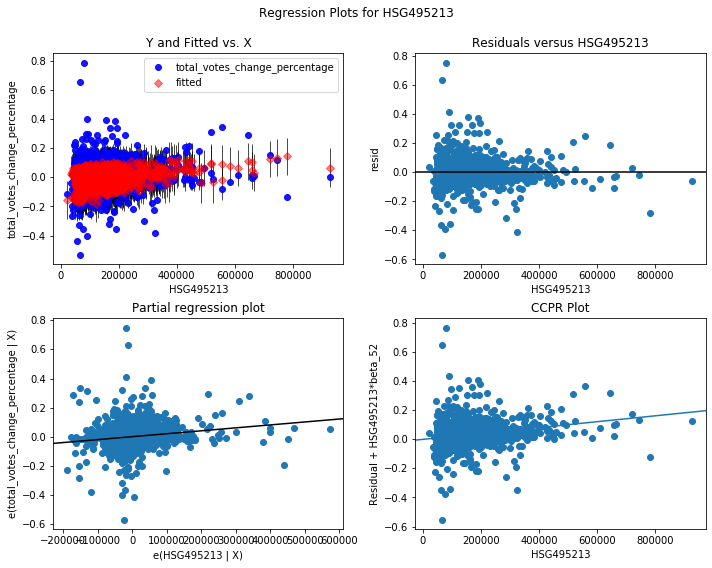

In [13]:
# Fitted results versus a single predictor
p = ['RHI225214','RHI325214', 'LFE305213', 'HSG495213']
import statsmodels.api as sm
fig = [0]*len(p)

for i in range(len(p)):
    fig[i] = plt.figure(figsize=(10,8))
    fig[i] = sm.graphics.plot_regress_exog(bfit1, p[i], fig=fig[i])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


state_abbr                              IA
total_votes_2012                      6388
votes_dem_2012                        3552
votes_gop_2012                        2836
PST045214                            12264
POP010210                            12439
AGE135214                              6.1
AGE295214                             23.8
AGE775214                             19.4
SEX255214                               50
RHI125214                            0.983
RHI225214                            0.006
RHI325214                              0.1
RHI425214                              0.3
RHI525214                                0
RHI625214                              0.7
RHI725214                            0.023
RHI825214                             96.2
POP715213                             91.6
POP645213                              1.8
POP815213                              4.2
EDU635213                             88.8
EDU685213                             13.8
VET605213  

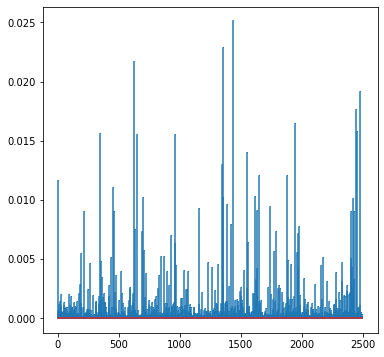

In [17]:
## check the leverage and influential points

influence = bfit2.get_influence()
#c is the distance and p is p-value
(c, P) = influence.cooks_distance
fig = plt.figure(figsize=(6,6))
fig = plt.stem(np.arange(len(c)), c, markerfmt=",") 
df.iloc[c.argmax()]

# Try Transformation

In [15]:
# Apply box-cox transformation to HSG495213 and refit the model 

df['HSG495213_transformed']= stats.boxcox(df['HSG495213'])[0]
# formula2 = 'total_votes_change_percentage ~ RHI225214_transformed + C(state_abbr) + RHI325214_transformed + LFE305213 + HSG495213_transformed + 1'
formula3 = 'total_votes_change_percentage ~ RHI225214 + C(state_abbr) + RHI325214 + LFE305213 + HSG495213_transformed + 1'

bfit3 = smf.ols(formula3, df).fit()

bfit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     total_votes_change_percentage   R-squared:                       0.393
Model:                                       OLS   Adj. R-squared:                  0.380
Method:                            Least Squares   F-statistic:                     30.49
Date:                           Sun, 26 Sep 2021   Prob (F-statistic):          3.57e-224
Time:                                   18:39:15   Log-Likelihood:                 3405.3
No. Observations:                           2500   AIC:                            -6705.
Df Residuals:                               2447   BIC:                            -6396.
Df Model:                                     52                                         
Covariance Type:                       nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -28.1338      2.685    -10.477      0.000     -33.399     -22.868
C(state_abbr)[T.AR]       0.0040      0.012      0.331      0.741      -0.020       0.028
C(state_abbr)[T.AZ]      -0.0331      0.020     -1.661      0.097      -0.072       0.006
C(state_abbr)[T.CA]      -0.0352      0.013     -2.626      0.009      -0.062      -0.009
C(state_abbr)[T.CO]      -0.0684      0.013     -5.297      0.000      -0.094      -0.043
C(state_abbr)[T.CT]      -0.0497      0.027     -1.822      0.069      -0.103       0.004
C(state_abbr)[T.DE]       0.0148      0.037      0.398      0.691      -0.058       0.088
C(state_abbr)[T.FL]       0.0381      0.012      3.120      0.002       0.014       0.062
C(state_abbr)[T.GA]       0.0145      0.010      1.424      0.155      -0.005       0.035
C(state_abbr)[T.HI]      -0.1335      0.033     -4.047      0.000      -0.198      -0.069
C(state_abbr)[T.IA]      -0.0885      0.012     -7.492      0.000      -0.112      -0.065
C(state_abbr)[T.ID]      -0.1378      0.014     -9.562      0.000      -0.166      -0.110
C(state_abbr)[T.IL]      -0.0424      0.011     -3.703      0.000      -0.065      -0.020
C(state_abbr)[T.IN]      -0.0204      0.012     -1.747      0.081      -0.043       0.002
C(state_abbr)[T.KS]      -0.0514      0.012     -4.412      0.000      -0.074      -0.029
C(state_abbr)[T.KY]       0.0168      0.011      1.483      0.138      -0.005       0.039
C(state_abbr)[T.LA]       0.0014      0.012      0.112      0.910      -0.023       0.025
C(state_abbr)[T.MA]      -0.0880      0.021     -4.280      0.000      -0.128      -0.048
C(state_abbr)[T.MD]      -0.0518      0.018     -2.926      0.003      -0.087      -0.017
C(state_abbr)[T.ME]      -0.0659      0.019     -3.516      0.000      -0.103      -0.029
C(state_abbr)[T.MI]      -0.0614      0.012     -5.051      0.000      -0.085      -0.038
C(state_abbr)[T.MN]      -0.1018      0.012     -8.445      0.000      -0.125      -0.078
C(state_abbr)[T.MO]      -0.0256      0.011     -2.279      0.023      -0.048      -0.004
C(state_abbr)[T.MS]      -0.0112      0.011     -0.983      0.326      -0.034       0.011
C(state_abbr)[T.MT]      -0.0747      0.013     -5.577      0.000      -0.101      -0.048
C(state_abbr)[T.NC]       0.0007      0.011      0.059      0.953      -0.021       0.022
C(state_abbr)[T.ND]      -0.0547      0.014     -3.970      0.000      -0.082      -0.028
C(state_abbr)[T.NE]      -0.0321      0.012     -2.679      0.007      -0.056      -0.009
C(state_abbr)[T.NH]      -0.0920      0.023     -4.002      0.000      -0.137      -0.047
C(state_abbr)[T.NJ]      -0.0021      0.018     -0.121      0.904      -0.036     

- We can see that the Adj. R-squared increase from 0.372 to 0.380 
- AIC decrease from -6670 to -6705

after apply the box-cox transformation while keep the same predictors 